# Lab 2: Introduction to Autoencoders

Welcome to a general overview of autoencoders. The idea of auto encoders is to allow a neural network to figure out how to best encode and decode certain data. The uses for autoencoders are really anything that you can think of where encoding could be useful. Some examples are in the form of compressing the number of input features and noise reduction.

Deep neural networks are often quite good at taking huge amounts of data and filtering through it to find answers and learn from data, but sometimes a model can benefit from simpler input, which is usually in the form of pruning down some of the features that arent as important, or even combining them somehow.

Autoencoders are an unsupervised learning approach to some of these issues and techniques.

# Creating Base Model: Autoencoders

To begin, we'll start with an example of both compression and augmentation. Compression is just taking some data that is of n size and attempting to make it smaller. Data augmentation can take many forms. In our case, we're going to take image data, pass it through some convolutional layers, flatten it to a vector of much less scalar data, and then show that we can take this small vector of values and decode it back to the original image representation.

Recent advances in sequential data, for example with transformers, might be a reason why we'd first do this. A transformer wants to take in a vector of values, not an image.

While you could certainly grayscale and flatten the image yourself, you'd still likely wish to compress this data down, but still keep a meaningful "description" of the data. You still could just append the same compression structure to the beginning of your models, and hope the model figures it out, or you can actually first train the encoder to do this exact thing, it will be much more likely to learn it better since this is the only task it's trying to fit to. Then you can append the encoder, without trainable parameters, to your transformer model, for example. This is one way that you could use typical transformer models on sequences of images and video data, but there are really many possibilities here. So let's see how it works by tinkering with some data.

To begin, we'll make some imports and get a basic dataset.

In [1]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1

Next, we wish to build the encoder and decoder. Often, the encoder and decoder are mirror representations of eachother, but this isnt actually necessary. If we're doing compression, we'd like to make sure we can decompress back to the original image, so we need to make sure it decodes back to the starting input data, but whatever happens in between doesn't have to be a perfect match.

Since we're using mnist, it's actually a fairly simple dataset. We can encode and decode this without much trouble at all, and it will give us the opportunity to show the bare minimum required for an autoencoder. Later, we can work with a more challenging dataset. In case you're not aware of what the mnist dataset is:

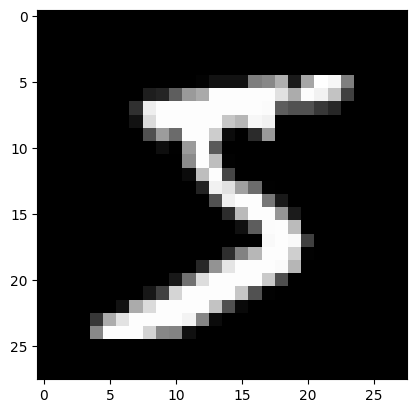

In [2]:
'''
# can use cv2 or matplotlib for visualizing:

cv2.imshow("example", x_train[0])
cv2.waitKey(1000)
'''

import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap="gray")

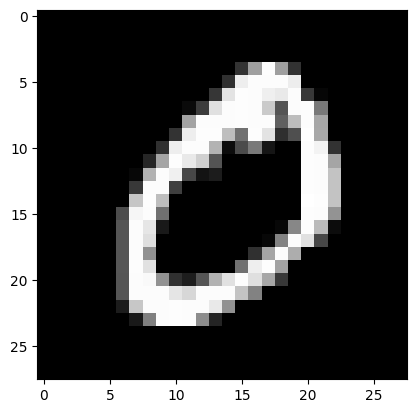

In [3]:
plt.imshow(x_train[1], cmap="gray")

The dataset consists of hand-written digits 0-9, usually used for classification, but we're going to use this dataset to learn about autoencoders!

First, we'll cover compression. So this data is 28x28 in pixel values:

In [4]:
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [5]:
x_train[0].shape

(28, 28)

In [6]:
28*28

784

Since the data is 28x28 pixel values, our data is 784 values, and the question first is... can we condense this amount of data down?

Again, why might we want to even do this? Take for example a classifier model. Initially, it's going to be taking in all 784 values, and it's going to first have to figure out which values actually matter, and which dont. For example, with this dataset, most of the times the values in the corners of the image are always going to be 0 and thus irrelevant. It's really in the minority of cases where the values actually matter in the case of the MNIST dataset, which is why this problem is actually extremely simple for neural networks to solve, and why this dataset actually makes for a great one to exemplify what autoencoders can do for us!

To begin, we'll start by making our encoder. After the encoder, we will build the decoder, and these two models together make our autoencoder.

The encoder begins with the input layer:

In [7]:
encoder_input = keras.Input(shape=(28, 28, 1), name='img')

Next, we'll just immediately flatten the data so it can be used with dense layers. Being an image, we could also use convolutional layers. Most image data is going to work best with, or even require, convolutional layers to some extent, then we could flatten them. In this case, however, it wont be required due to the simplicity of this dataset.

In [8]:
x = keras.layers.Flatten()(encoder_input)

In fact, we can go straight to compression after flattening:

In [9]:
encoder_output = keras.layers.Dense(64, activation="relu")(x)

That's it. So all this model does is take input of 28x28, flatten to a vector of 784 values, then go to a fully-connected dense layer of a mere 64 values.

In [10]:
64/784

0.08163265306122448

Should this work, that would mean we've compressed to a mere 8% of the original data. The "auto" part of this encoder is the dense neural network layer, and the weights/biases associated, which are going to be responsible for figuring out how to best compress these values.

With that, we're actually done with our encoder already:

In [11]:
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

Now, we want to define our decoder. The decoder's job is going to be to take this vector of 64 (at the moment) values and then "decompress" it back to the original image.

As mentioned earlier, the decoder is often a mirror representation of the encoder, but this isn't essential. In the case of images, you will need to take care with pooling layers, so as to make sure that you upsample to the same resolution, but, again, this only needs to end at the same target as the input, and how you get there can be unique. For now, we'll match the encoder by starting with a dense layer of 64 values:

In [12]:
decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)

This layer is probably not even required, but we'll add it in since more challenging problems will need some sort of extra layer. From here, we've got 64 values, but 64 values isn't our 28x28 image. How do we get back to that? First off, we need 784 values. We might as well let our neural network figure that out for us, so we'll just make a dense layer of 784 values.

In [13]:
x = keras.layers.Dense(784, activation="relu")(decoder_input)

Finally, our image isn't a vector of 784 values, it's a 2D array of 28 x 28 values, so we'll throw that into our model as the output in the form of a reshape:

In [14]:
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

Now we have our decoder model done. In the case of compression, it might be possible that you'd actually use a deep neural network to compress information for the purposes of decompressing it later, but this isn't really the use-case with neural networks.

In general the idea is to make the job of learning some task for a neural network easier by first simplifying and "denoising" the input. For example, if our autoencoder works, it means that we were able to take 784 input values and condense them to just 64. 64 input features is going to be far easier for a neural network to build a classifier from than 784, so long as those 64 features are just as, or almost as, descriptive as the 784, and that's essentially what our autoencoder is attempting to figure out.

Now that the model architecture is done, we'll set an optimizer:

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

We'll also combine this encoder and decoder into a singular "autoencoder" model:

In [16]:
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')

We can inspect our created model:

In [17]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 784)               50960     
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 105360 (411.56 KB)
Trainable params: 1053

In the case of an autoencoder, our input is usually going to need to match the full model output. So our input layer data was the 28x28 image:

```
img (InputLayer) [(None, 28, 28, 1)] 0
```

And then we can see the output reshape layer is:

```
reshape (Reshape) (None, 28, 28, 1) 0
```

So this model will return to us the same shape of data, and we're hoping its a picture that is the same as our input was, which means our bottleneck of 64 values was a successful compression.

We'll now compile our model with the optimizer and a loss metric. We'll use mean squared error for loss (mse).

In [18]:
autoencoder.compile(opt, loss='mse')

We're ready to train, so we'll specify some epochs and save our model each time:

In [19]:
epochs=3

for epoch in range(epochs):

    history = autoencoder.fit(
      x_train,
      x_train,
      epochs=1, 
      batch_size=32, validation_split=0.10
        )   
    autoencoder.save(f"models/AE-{epoch+1}.model")

1688/1688 [==============================] - 2s 977us/step - loss: 0.0222 - val_loss: 0.0153
INFO:tensorflow:Assets written to: models/AE-1.model/assets


INFO:tensorflow:Assets written to: models/AE-1.model/assets


1688/1688 [==============================] - 2s 975us/step - loss: 0.0146 - val_loss: 0.0138
INFO:tensorflow:Assets written to: models/AE-2.model/assets


INFO:tensorflow:Assets written to: models/AE-2.model/assets


1688/1688 [==============================] - 2s 985us/step - loss: 0.0136 - val_loss: 0.0132
INFO:tensorflow:Assets written to: models/AE-3.model/assets


INFO:tensorflow:Assets written to: models/AE-3.model/assets


## Base Model Analysis: Encoded Vector of 64
Looks like indeed everything at least runs. Before we inspect things, let's see the full code up to this point!

In [20]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np


(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1


encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(64, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse')

epochs=3

for epoch in range(epochs):

    history = autoencoder.fit(
      x_train,
      x_train,
      epochs=1, 
      batch_size=32, validation_split=0.10
        )   
    autoencoder.save(f"models/AE-{epoch+1}.model")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 784)               50960     
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 105360 (411.56 KB)
Trainable params: 1053

INFO:tensorflow:Assets written to: models/AE-1.model/assets


1688/1688 [==============================] - 2s 948us/step - loss: 0.0142 - val_loss: 0.0135
INFO:tensorflow:Assets written to: models/AE-2.model/assets


INFO:tensorflow:Assets written to: models/AE-2.model/assets


1688/1688 [==============================] - 2s 946us/step - loss: 0.0133 - val_loss: 0.0130
INFO:tensorflow:Assets written to: models/AE-3.model/assets


INFO:tensorflow:Assets written to: models/AE-3.model/assets


First, let's look at an encoded example, because it's cool:

In [21]:
example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

print(example[0].shape)
print(example[0])

1/1 [==============================] - 0s 30ms/step
(64,)
[0.72237897 1.0948427  0.35136658 2.8410792  0.         0.76346624
 0.8616381  1.27796    0.         1.7522587  1.9503517  0.
 0.79834473 0.37280732 1.6466222  2.2892406  0.         0.
 2.109713   0.         2.028581   0.         2.5360851  0.456301
 1.244502   2.3648822  1.9619437  1.417202   0.         0.
 1.9793673  1.5909249  1.4514728  1.1120297  1.0063684  1.8363674
 0.45796973 0.9572411  0.44553566 0.44627106 0.20619859 1.5035799
 0.7612391  1.1314489  1.2992896  2.860348   0.         1.0393187
 1.5354183  2.0310397  0.88720244 0.41984186 0.7683874  0.831504
 2.2013338  1.8436778  1.7696031  2.2495286  0.89590794 0.
 0.45361748 2.156787   1.0529529  0.95354545]


Just for fun, let's visualize an 8x8 of this vector of 64 values:

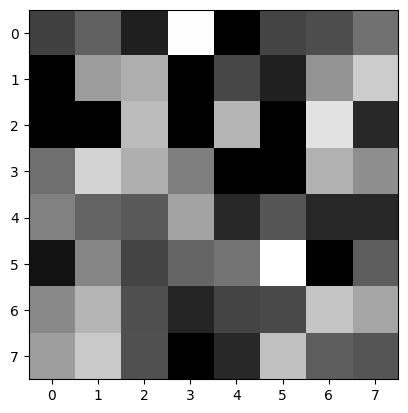

In [22]:
plt.imshow(example[0].reshape((8,8)), cmap="gray")

Okay, that doesn't look very meaningful to us, but... did it work? Let's see what x_test[0] was:

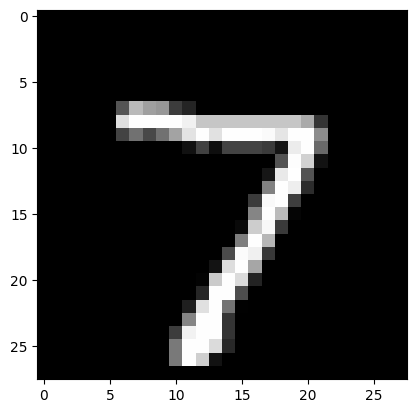

In [23]:
plt.imshow(x_test[0], cmap="gray")

Okay, let's see how it looks after going through the autoencoder and at least, after encoding, that 7 was encoded to be:

1/1 [==============================] - 0s 25ms/step


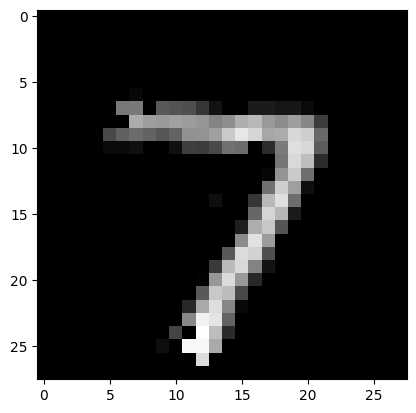

In [24]:
ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

While we can clearly see some dead zone here, and it also looks like values are a little decreased, it's still very clearly a 7, it's in the same placement as the original and very much in the same general shape. Again, we were able to decode the above 7 from:

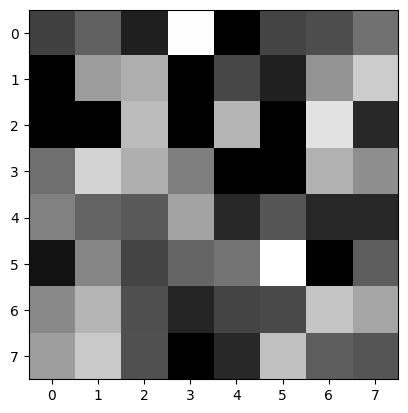

In [25]:
plt.imshow(example[0].reshape((8,8)), cmap="gray")

That's COOL!

Using OpenCV, we can quickly cycle through a bunch of examples by doing:

In [26]:
# for d in x_test[:2]:  # just show 2 examples, feel free to show all or however many you want!

#     ae_out = autoencoder.predict([ d.reshape(-1, 28, 28, 1) ])
#     img = ae_out[0]

#     cv2.imshow("decoded",img)
#     cv2.imshow("original",np.array(d))
#     cv2.waitKey(1000)  # wait 1000ms, 1 second, and then show the next.

At this point, you may be wondering why we don't just resize our 28x28 images to 8x8 and get the same impact? That may actually work, but remember: autoencoders are not Just for images, nor are they intended really for actually compressing data. The idea is to simplify the data. If you resize an image down to 8x8 then back up to 28x28, it's definitely going to look far worse than what we've got here:

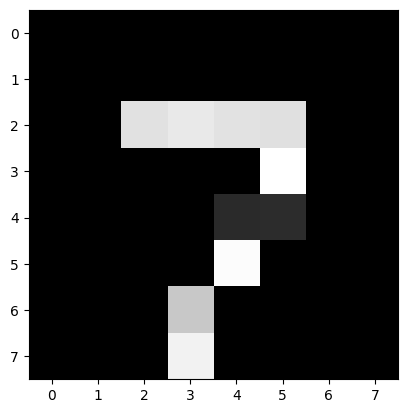

In [27]:
smaller = cv2.resize(x_test[0], (8,8))
back_to_original = cv2.resize(smaller, (28,28))
plt.imshow(smaller, cmap="gray")

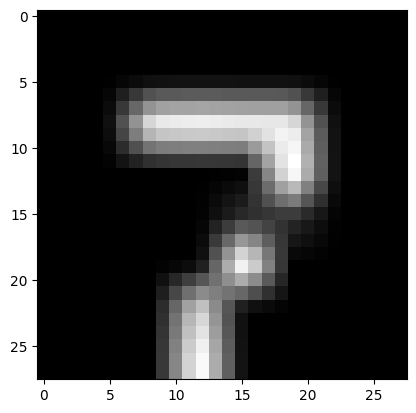

In [28]:
plt.imshow(back_to_original, cmap="gray")

It's certainly still a 7, but, to me, it's clear the autoencoder's 7 is far more like the original.

## Base Model Analysis: Encoded Vector of 25

Continuing along, are there some changes we could make? Could we compress more?!

Let's make the bottleneck 25 neurons, which would effectively be a 5x5 if we reshaped it.

In [29]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np


(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1


encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(25, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(25, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse')

epochs=3

for epoch in range(epochs):

    history = autoencoder.fit(
      x_train,
      x_train,
      epochs=1, 
      batch_size=32, validation_split=0.10
        )   
    autoencoder.save(f"models/AE-{epoch+1}.model")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 25)                19625     
                                                                 
 dense_7 (Dense)             (None, 25)                650       
                                                                 
 dense_8 (Dense)             (None, 784)               20384     
                                                                 
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 40659 (158.82 KB)
Trainable params: 40659

INFO:tensorflow:Assets written to: models/AE-1.model/assets


1688/1688 [==============================] - 1s 659us/step - loss: 0.0246 - val_loss: 0.0242
INFO:tensorflow:Assets written to: models/AE-2.model/assets


INFO:tensorflow:Assets written to: models/AE-2.model/assets


1688/1688 [==============================] - 1s 649us/step - loss: 0.0239 - val_loss: 0.0233
INFO:tensorflow:Assets written to: models/AE-3.model/assets


INFO:tensorflow:Assets written to: models/AE-3.model/assets


1/1 [==============================] - 0s 31ms/step
(25,)
[0.8942441 1.6355579 4.90595   1.9123423 0.        2.5601308 4.061474
 0.9722612 2.3310528 2.214645  3.0003684 0.        2.2281692 1.4898884
 1.4419997 2.6054296 1.1842885 1.0159075 2.8929412 4.289458  2.854616
 1.7997881 2.0924656 4.165448  0.6389349]


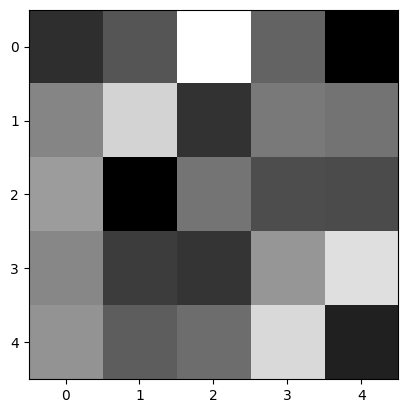

In [30]:
example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

print(example[0].shape)
print(example[0])
plt.imshow(example[0].reshape((5,5)), cmap="gray")

So this is a our 784-value number 7 compressed down from a 28x28 to 25 values in a 5x5 format. Let's see what the decompressed version looks like:

1/1 [==============================] - 0s 25ms/step


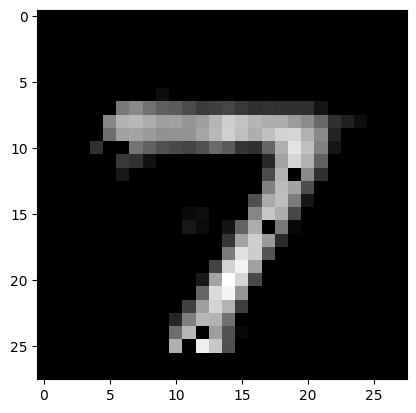

In [31]:
ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

Recall the original was:

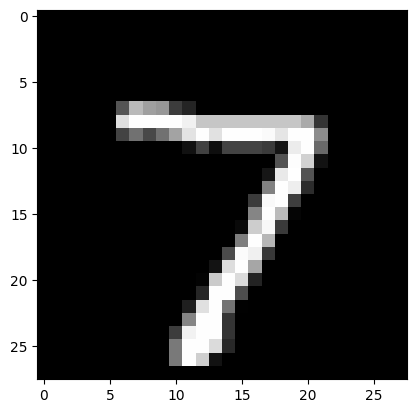

In [32]:
plt.imshow(x_test[0], cmap="gray")

So this one is definitely not quite as good, but again, it's certainly better than the resized variant:

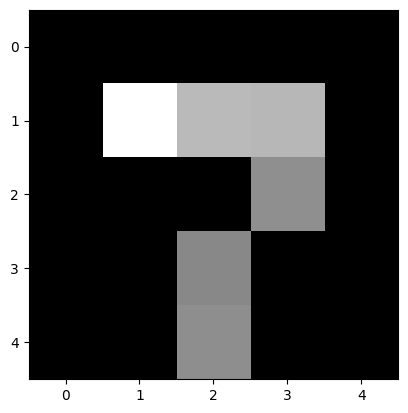

In [33]:
smaller = cv2.resize(x_test[0], (5,5))
back_to_original = cv2.resize(smaller, (28,28))
plt.imshow(smaller, cmap="gray")

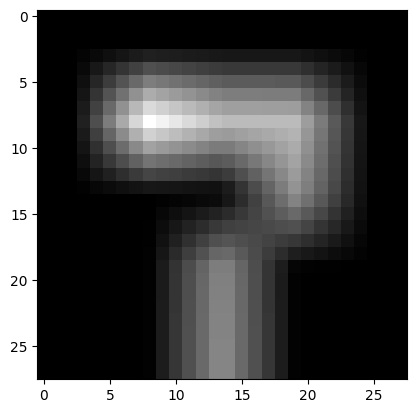

In [34]:
plt.imshow(back_to_original, cmap="gray")

## Base Model Analysis: Encoded Vector of 9

Can we... go even lower? What about a vector of only 9 values?

In [35]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np


(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1


encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(9, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(9, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse')

epochs=3

for epoch in range(epochs):

    history = autoencoder.fit(
      x_train,
      x_train,
      epochs=1, 
      batch_size=32, validation_split=0.10
        )   
    autoencoder.save(f"models/AE-{epoch+1}.model")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 9)                 7065      
                                                                 
 dense_10 (Dense)            (None, 9)                 90        
                                                                 
 dense_11 (Dense)            (None, 784)               7840      
                                                                 
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 14995 (58.57 KB)
Trainable params: 14995 

INFO:tensorflow:Assets written to: models/AE-1.model/assets


1688/1688 [==============================] - 1s 489us/step - loss: 0.0400 - val_loss: 0.0390
INFO:tensorflow:Assets written to: models/AE-2.model/assets


INFO:tensorflow:Assets written to: models/AE-2.model/assets


1688/1688 [==============================] - 1s 515us/step - loss: 0.0392 - val_loss: 0.0391
INFO:tensorflow:Assets written to: models/AE-3.model/assets


INFO:tensorflow:Assets written to: models/AE-3.model/assets


1/1 [==============================] - 0s 18ms/step
(9,)
[3.6108944 3.6753771 3.1528475 3.3975375 7.938446  5.513242  1.1056042
 3.5083306 4.891431 ]


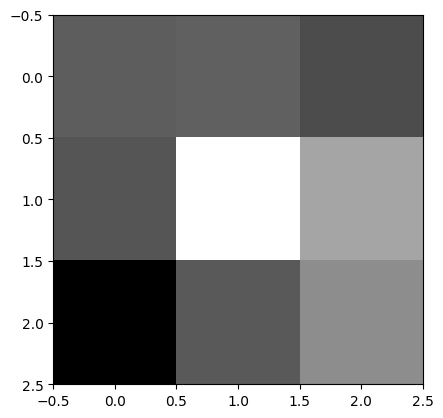

In [36]:
example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

print(example[0].shape)
print(example[0])
plt.imshow(example[0].reshape((3,3)), cmap="gray")

1/1 [==============================] - 0s 25ms/step


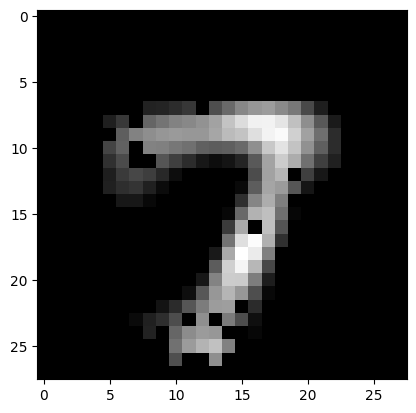

In [37]:
ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

You've got to be kidding me. How about some others?

1/1 [==============================] - 0s 8ms/step


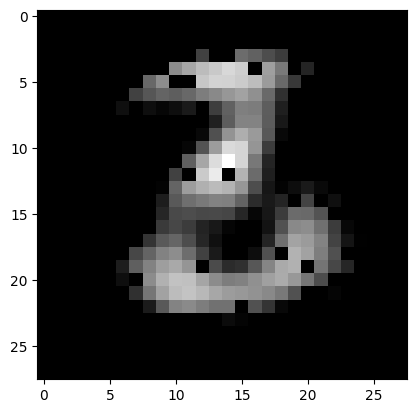

In [38]:
ae_out = autoencoder.predict([ x_test[1].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

This was probably a 3, definitely hard to tell for sure, so we can check the original:

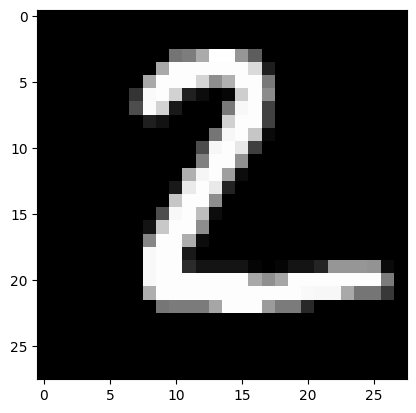

In [39]:
plt.imshow(x_test[1], cmap="gray")

Okay so that one didn't go so well. Let's check a few others:

1/1 [==============================] - 0s 9ms/step


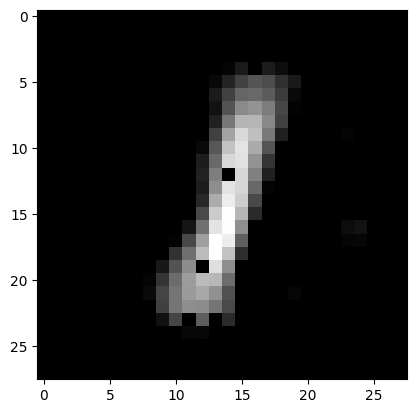

In [40]:
ae_out = autoencoder.predict([ x_test[2].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

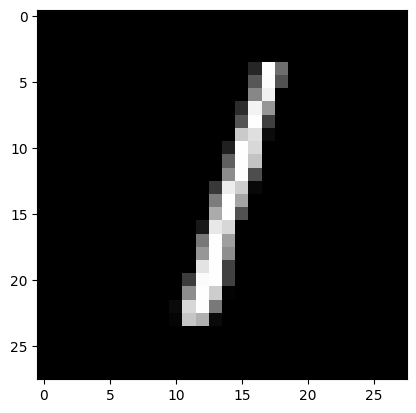

In [41]:
plt.imshow(x_test[2], cmap="gray")

1/1 [==============================] - 0s 8ms/step


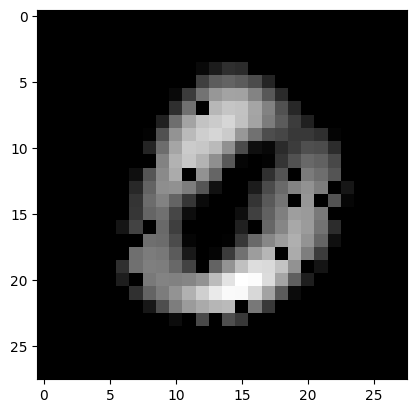

In [42]:
ae_out = autoencoder.predict([ x_test[3].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

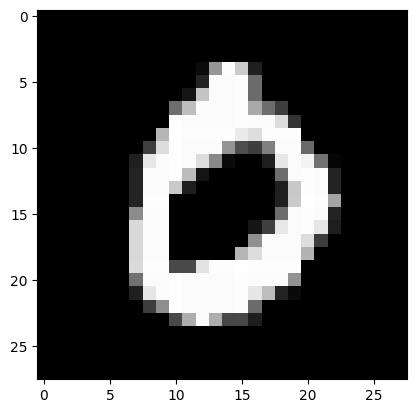

In [43]:
plt.imshow(x_test[3], cmap="gray")

1/1 [==============================] - 0s 8ms/step


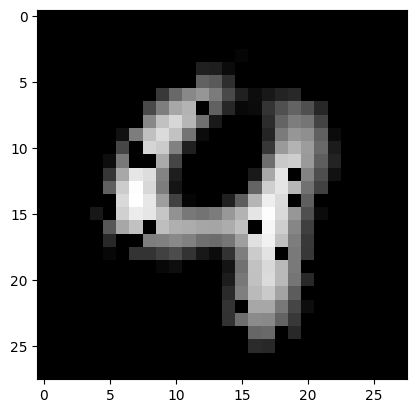

In [44]:
ae_out = autoencoder.predict([ x_test[4].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

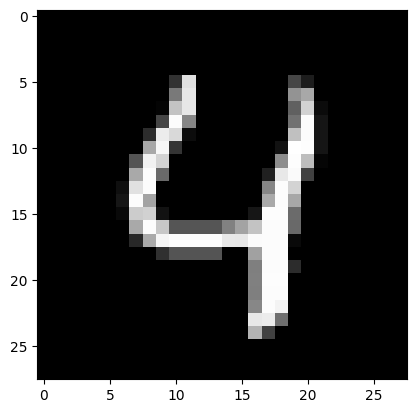

In [45]:
plt.imshow(x_test[4], cmap="gray")

1/1 [==============================] - 0s 9ms/step


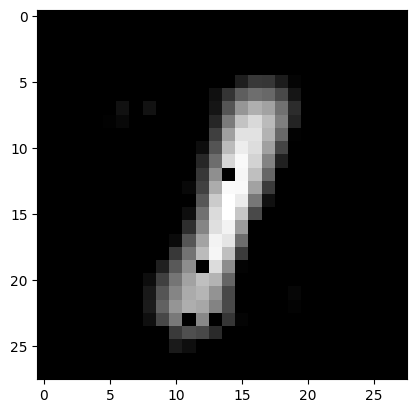

In [46]:
ae_out = autoencoder.predict([ x_test[5].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

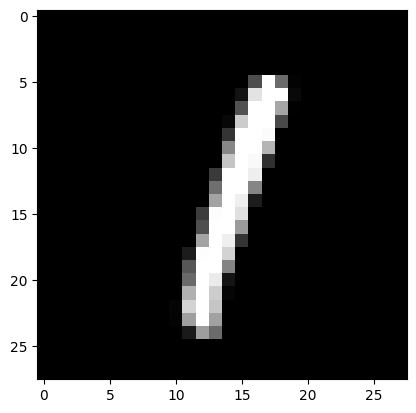

In [47]:
plt.imshow(x_test[5], cmap="gray")

As shown earlier, you can just iterate through a bunch of examples by doing something like:

In [48]:
# for d in x_test[:30]:  # just show 5 examples, feel free to show all or however many you want!

#     ae_out = autoencoder.predict([ d.reshape(-1, 28, 28, 1) ])
#     img = ae_out[0]

#     cv2.imshow("decoded",img)
#     cv2.imshow("original",np.array(d))
#     cv2.waitKey(1000)  # wait 1000ms, 1 second, and then show the next.

## Base Model Analysis: Overall

Surprisingly, this works for most of the numbers still, which is frankly incredible, and 9/784 is ~ 1%. Of course I wouldn't recommend going THIS small, but it is interesting to see how well the autoencoder can indeed condense information.

# Analysing Model: Noise Reduction

One argument that we've made so far for autoencoders is noise-reduction. Autoencoders are a form of unsupervised learning, in that they can determine what's noise and what isn't, just by seeing a bunch of examples of the data, without us needing to tell or teach it to ignore noise.

Again, we'll use this MNIST data to exemplify this, but just like everything else, this works with any type of data.

Let's start by going back to our compression to a vector of 64 values:

In [49]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np


(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset

x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1


encoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(64, activation="relu")(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(opt, loss='mse')

epochs=3

for epoch in range(epochs):

    history = autoencoder.fit(
      x_train,
      x_train,
      epochs=1, 
      batch_size=32, validation_split=0.10
        )   
    autoencoder.save(f"models/AE-{epoch+1}.model")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 784)               50960     
                                                                 
 reshape_4 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 105360 (411.56 KB)
Trainable params: 1053

INFO:tensorflow:Assets written to: models/AE-1.model/assets


1688/1688 [==============================] - 2s 948us/step - loss: 0.0140 - val_loss: 0.0134
INFO:tensorflow:Assets written to: models/AE-2.model/assets


INFO:tensorflow:Assets written to: models/AE-2.model/assets


1688/1688 [==============================] - 2s 924us/step - loss: 0.0130 - val_loss: 0.0128
INFO:tensorflow:Assets written to: models/AE-3.model/assets


INFO:tensorflow:Assets written to: models/AE-3.model/assets


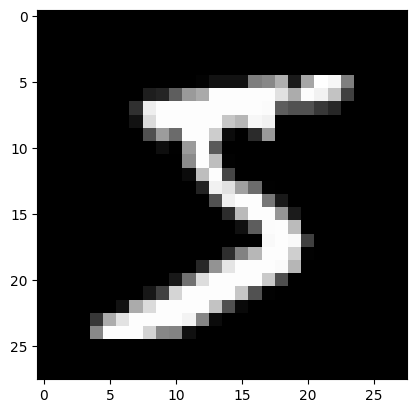

In [50]:
plt.imshow(x_train[0], cmap="gray")

Now, let's build a function to add noise:

In [51]:
import random


def add_noise(img, random_chance=5):
    noisy = []
    for row in img:
        new_row = []
        for pix in row:
            if random.choice(range(100)) <= random_chance: 
                new_val = random.uniform(0, 1)
                new_row.append(new_val)
            else:
                new_row.append(pix)
        noisy.append(new_row)
    return np.array(noisy)

All this function does is iterate through each pixel and randomly, with a default of 5%, change the pixel to be white.

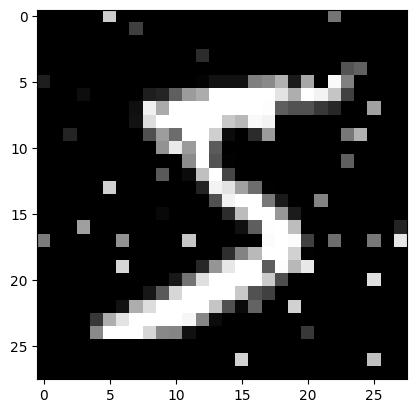

In [52]:
noisy = add_noise(x_train[0])
plt.imshow(noisy, cmap="gray")

Here we have a very noisy "5." What happens if we feed this noisy 5 through our autoencoder?

1/1 [==============================] - 0s 23ms/step


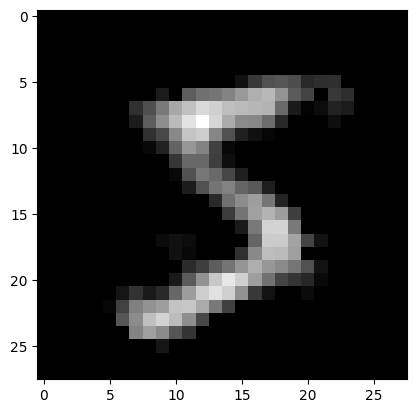

In [53]:
ae_out = autoencoder.predict([ noisy.reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

while not perfectly cleaned, you can see that a most of the noise has been removed.

# Anslysing Model: Gap Filling

What about filling in gaps?

In [54]:
def remove_values(img, random_chance=5):
    noisy = []
    for row in img:
        new_row = []
        for pix in row:
            if random.choice(range(100)) <= random_chance: 
                new_val = 0  # changing this to be 0 
                new_row.append(new_val)
            else:
                new_row.append(pix)
        noisy.append(new_row)
    return np.array(noisy)

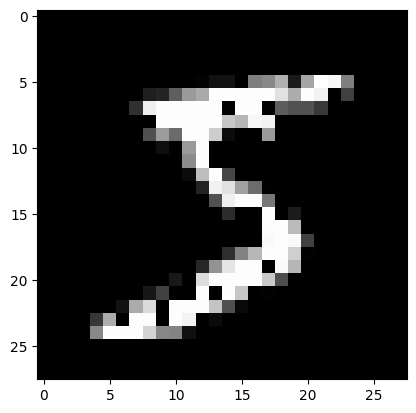

In [55]:
some_hidden = remove_values(x_train[0], random_chance=15)  # slightly higher chance so we see more impact
plt.imshow(some_hidden, cmap="gray")

1/1 [==============================] - 0s 8ms/step


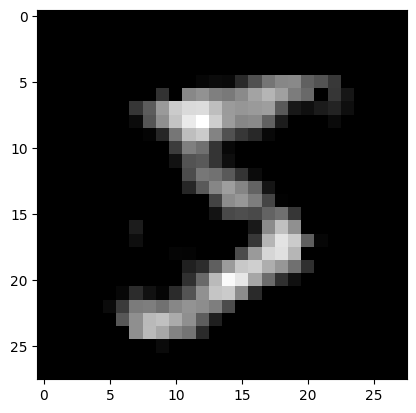

In [56]:
ae_out = autoencoder.predict([ some_hidden.reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

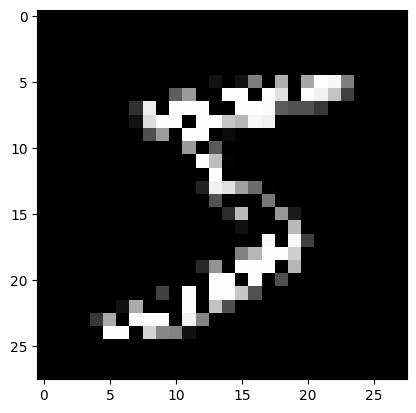

In [57]:
some_hidden = remove_values(x_train[0], random_chance=35)  # slightly higher chance so we see more impact
plt.imshow(some_hidden, cmap="gray")

1/1 [==============================] - 0s 9ms/step


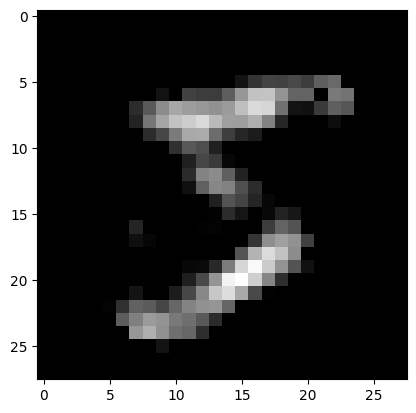

In [58]:
ae_out = autoencoder.predict([ some_hidden.reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

# Conclusion

So there you have some image-based examples of autoencoders and what they can do. Autoencoders can be used in the same way for other types of data too, so definitely try them out next time you have a large number of features in your neural network's input!